In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Display the row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

#first_row = session.query(Station).first()
#first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11a85bd0438>,
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01'}

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
    
# Calculate the date 1 year ago from the last data (l_date) point in the database
l_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(l_date)

# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-22').all()
#print(prcp_query)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data = pd.DataFrame(prcp_query, columns=['date','precipitation'])

# Sort the dataframe by date
prcp_data.set_index(prcp_data['date'], inplace = True)
prcp_data = prcp_data.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
#prcp_data = prcp_data.dropna().set_index("date")
prcp_data.head()

('2017-08-23',)


,date,precipitation
date,,
2016-08-23,2016-08-23,0.00
2016-08-23,2016-08-23,NaN
2016-08-23,2016-08-23,1.79
2016-08-23,2016-08-23,0.05
2016-08-23,2016-08-23,0.15


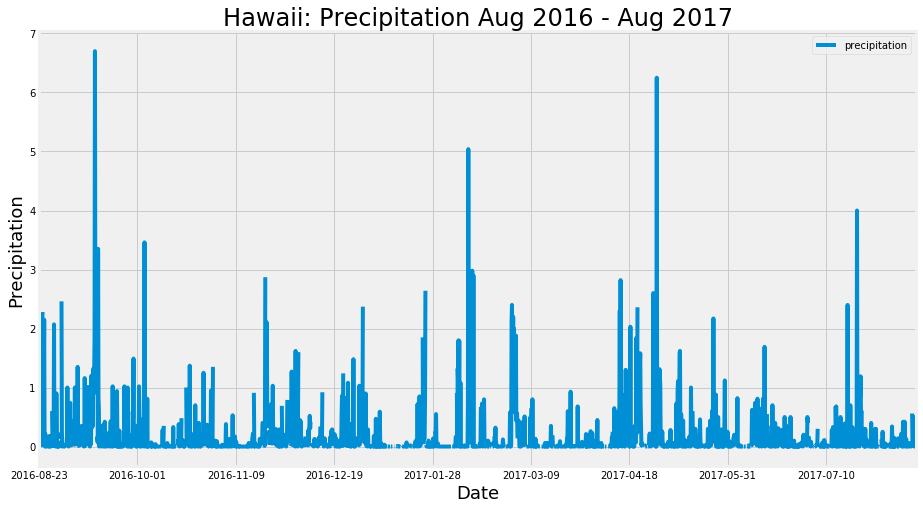

In [14]:
prcp_data.plot()

plt.rcParams["figure.figsize"] = (14,8)
plt.title("Hawaii: Precipitation Aug 2016 - Aug 2017", fontsize=24)
plt.xlabel("Date",fontsize = 18)
plt.ylabel("Precipitation",fontsize =18)
#plt.tight_layout()
plt.savefig("Images/hawaii_prcp.png")
#plt.legend("Precipitation",loc='left top', fontsize=10)



![precipitation](Images/precipitation.png)

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [16]:
# Design a query to show how many stations are available in this dataset?
nbr_station = session.query(Station.station).count()
nbr_station

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_ct_list = session.query(Measurement.station,Measurement.tobs).all()
#station_ct_list = pd.DataFrame(station_ct_list, columns=['station', 'tobs'])
station_ct_list = pd.DataFrame(station_ct_list).groupby("station").count().sort_values("tobs", ascending = False)
station_ct_list

#prcp_data = pd.DataFrame(prcp_query, columns=['date','precipitation'])

,tobs
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_ct_list.index[0]
data_query = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == station_ct_list.index[0])
for data in data_query:
    print(data)


(54.0, 85.0, 71.66378066378067)


In [20]:
# Choose the station with the highest number of temperature observations.
highest_temp_obs_stn = session.query(Measurement.station,Measurement.tobs).all()
highest_temp_obs_stn = pd.DataFrame(highest_temp_obs_stn).groupby("station").count().sort_values("tobs", ascending = False)
highest_temp_obs_stn.index[0]
#highest_temp_obs_stn

'USC00519281'

In [21]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_month_list = session.query(Measurement.station,Measurement.date,Measurement.tobs).\
    filter(Measurement.date > '2016-08-22',Measurement.station == 'USC00519281').all()
station_month_list = pd.DataFrame(station_month_list).groupby("date").mean().sort_values("date", ascending = True)
station_month_list.head()

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


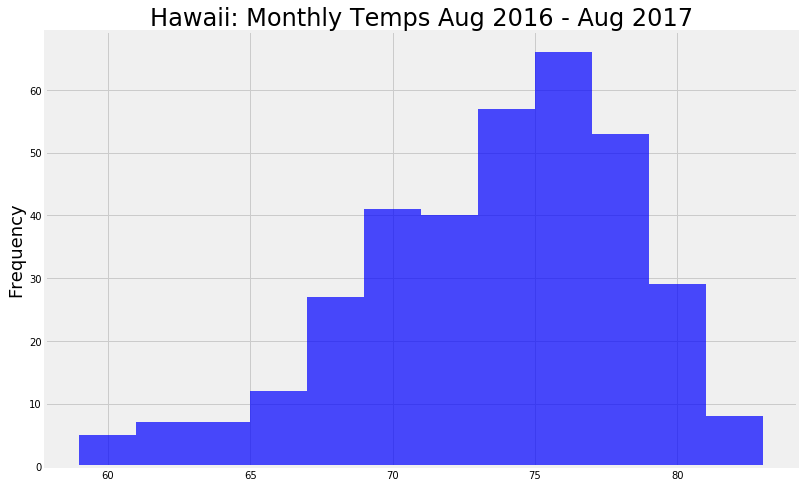

In [22]:
# Plot results as a histogram

plt.rcParams["figure.figsize"] = (12,8)
x = station_month_list['tobs']
n, bins, patches=plt.hist(x, bins=12, color='blue', alpha=0.7)
plt.title("Hawaii: Monthly Temps Aug 2016 - Aug 2017", fontsize=24)
#plt.xlabel("Temperatures",fontsize = 18)
plt.ylabel("Frequency",fontsize =18)
#plt.tight_layout()
plt.savefig("Images/hawaii_month_temps.png")

![precipitation](Images/station-histogram.png)

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Think I'll take my kids on a birthday vacation 2016-09-23 thru 2016-09-30
start_day = "2016-09-23"
end_day = "2016-09-30"
trip_temp = calc_temps(start_day,end_day)
trip_temp
trip_temp[0][1]


78.54716981132076

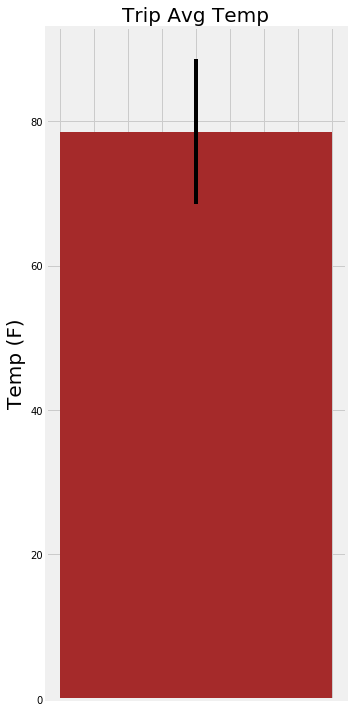

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig,ax=plt.subplots(figsize=[5,10])
plt.bar(0,trip_temp[0][1],color ="brown",yerr = (trip_temp[0][2] - trip_temp[0][0]))
ax.set_xticklabels([])
plt.ylabel("Temp (F)",fontsize =20)
plt.title("Trip Avg Temp",fontsize =20)
plt.tight_layout()
plt.savefig("Images/vacation_trip_avtemp.png")
plt.show()


In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
vac_trip_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,\
                              func.sum(Measurement.prcp)).filter(Station.station == Measurement.station).\
                              filter(Measurement.date >= start_day).filter(Measurement.date <= end_day).\
                              group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()
for data in vac_trip_rainfall:
    print(data)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.58)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.1599999999999997)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.23)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.7200000000000001)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.43)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.08)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.04)


In [ ]:
##STEP 2 - CLIMATE APP -- SEE appy.py

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
